In [1]:
from netCDF4 import Dataset

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import xarray as xr
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import numpy as np 

## Data collection

In [20]:
# Function to clip the TIFF file
def clip_tiff(file_path, lon_min, lon_max, lat_min, lat_max):
    data = rxr.open_rasterio(file_path)
    clipped_data = data.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
    return clipped_data

### Define the bounding box

In [22]:
south_korea_lat_min = 38
south_korea_lat_max = 39
south_korea_lon_min = 126
south_korea_lon_max = 128.5

### Aggregate data files

In [23]:
# Base directory containing the folders
base_dir = '/home/tom/Documents/UC/Pixel data'

# Dataset to store the clipped data
dataset = []
counter = 0
# Loop through each year directory
for year in os.listdir(base_dir):
    year_dir = os.path.join(base_dir, year)

    # Loop through each subdirectory in the year directory
    for root, dirs, files in os.walk(year_dir):
        for file in files:
            if file.endswith("-CL.tif"):
                file_path = os.path.join(root, file)

                # Extract the 'month' from the directory name if necessary
                month = os.path.basename(root)  # or any other logic to determine the month from the folder name

                # Clip the data and add to the dataset
                clipped_data = clip_tiff(file_path, south_korea_lon_min, south_korea_lon_max, south_korea_lat_min, south_korea_lat_max)
                clipped_data = clipped_data.squeeze() # Remove the band data
                clipped_data = clipped_data.assign_coords({"month": counter})
                clipper_data = clipped_data.expand_dims(dim = "month")
                dataset.append(clipped_data)
                counter += 1

# Concatenate all DataArrays in the dataset list along the 'month' dimension
combined_data = xr.concat(dataset, dim="month")

combined_data.rio.to_raster("combined-CL-smaller.tif")

In [24]:
combined_data.shape

(240, 447, 1114)

In [31]:
combined_data[0][2000][0]

<xarray.DataArray ()>
array(0, dtype=uint8)
Coordinates:
    band         int64 1
    x            float64 125.0
    y            float64 34.51
    spatial_ref  int64 0
    month        int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

## Data visualisation

In [16]:
import matplotlib.animation as animation
import matplotlib.colorbar as colorbar

In [1]:
fig, ax = plt.subplots()
test = ax.imshow(combined_data[0])

ax2, _ = colorbar.make_axes(plt.gca())
cbar = colorbar.ColorbarBase(ax2)
#cbar.set_clim(0, 100)

plt.show()

NameError: name 'plt' is not defined

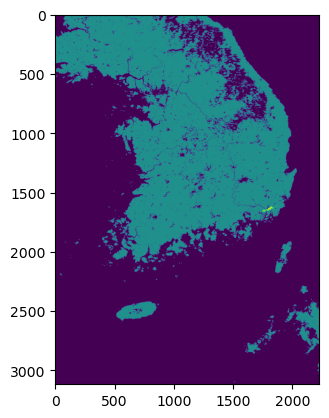

In [5]:
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(combined_data[i])

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=240, interval = 50)


#plt.show()

In [38]:
# To save the animation using Pillow as a gif
writer = animation.PillowWriter()
ani.save('scatter.gif', writer=writer)

KeyboardInterrupt: 

## 

In [2]:
combined_data = rxr.open_rasterio('combined-CL.tif')
combined_data

<xarray.DataArray (band: 240, y: 3118, x: 2227)>
[1666508640 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240
  * x            (x) float64 125.0 125.0 125.0 125.0 ... 130.0 130.0 130.0 130.0
  * y            (y) float64 39.0 39.0 39.0 38.99 ... 32.01 32.01 32.0 32.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [4]:
for i, data in enumerate(combined_data):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    combined_data[i] = new_data
#np.unique(combined_data)
#combined_data

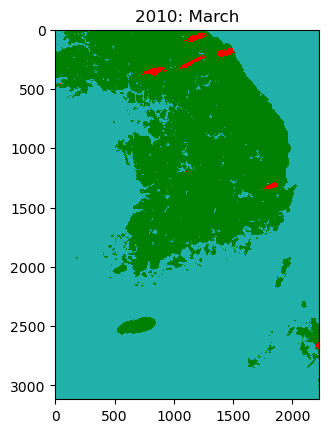

In [17]:
month_dict = {
    0 : 'January',
    1 : 'February',
    2:  'March',
    3: 'April',
    4: 'May',
    5: 'June',
    6: 'July',
    7: 'August',
    8: 'September',
    9: 'October',
    10: 'November',
    11: ' December'
}

n = 110
#cmap = {0: 'lightseagreen', 1: 'gold', 2: 'darkorange'}
cmap = mpl.colors.ListedColormap(["lightseagreen", "green", "red"])
fig, ax = plt.subplots()
test = ax.imshow(combined_data[n], cmap=cmap, vmin=0, vmax=2)
ax.set_title(f'{2001 + (n // 12)}: {month_dict[n % 12]}')
#print(np.unique(combined_data[n]))
#ax2, _ = colorbar.make_axes(plt.gca())
#cbar = colorbar.ColorbarBase(ax2)
#cbar.set_clim(0, 100)

plt.show()

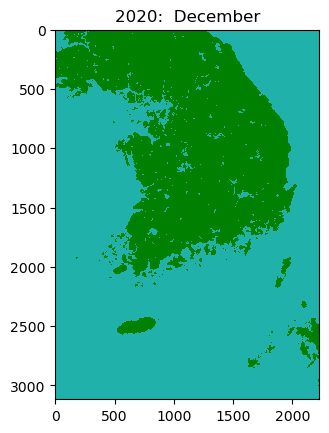

In [25]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    object = ax.imshow(combined_data[i], cmap=cmap, vmin=0, vmax=2)
    ax.set_title(f'{2001 + (i // 12)}: {month_dict[i % 12]}')
    return [object]

ani = animation.FuncAnimation(fig, animate, repeat=False, blit=True, frames=240, interval=400)
# To save the animation using Pillow as a gif

ani.save('scatter.gif', writer=animation.PillowWriter(fps=1))

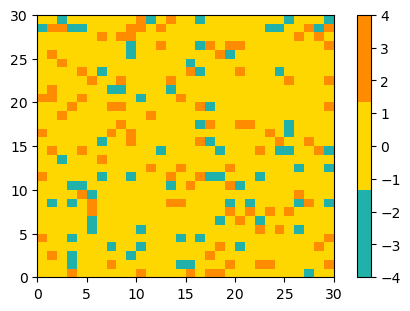

In [29]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

cmap = mpl.colors.ListedColormap(["lightseagreen", "gold", "darkorange"])
#viridis = mpl.colormaps['viridis']
#print(viridis)
plot_examples([cmap])

## STAR implementation

In [6]:
from scipy.signal import convolve2d
from scipy import optimize

Star works on non-categorized dataset.

In [26]:
def STAR(dataset, rho, c, phi, labda):
    '''
    Calculates the Space-Time Autoregression for a dataset Y using rho timelags. 
    
    Parameters:
    dataset: dataset for which to calculate the next timestep. First axis is the time-axis
    rho: maximum timelag 
    c: constant
    phi: parametervector of size tau
    labda: parametervector of size tau
    
    returns: predicction for dataset at timestep t. Same shape as a single timeslice of the dataset.
    '''
    
    y_t = np.zeros(shape=(dataset.shape[1], dataset.shape[2])) #initialize matrix
    y_t += c #add constant
    for tau in range(rho):
        y_t += phi[tau] * dataset[-(1+tau)] 
        y_t += labda[tau] * convolve2d(dataset[-(1+tau)], [[0,1,0],[1,0,1],[0,1,0]], mode='same') # rook's case convolution
        
    return y_t


In [27]:
combined_data = rxr.open_rasterio('combined-CL-smaller.tif')
combined_data

<xarray.DataArray (band: 240, y: 447, x: 1114)>
[119509920 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240
  * x            (x) float64 126.0 126.0 126.0 126.0 ... 128.5 128.5 128.5 128.5
  * y            (y) float64 39.0 39.0 39.0 38.99 38.99 ... 38.01 38.0 38.0 38.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

In [28]:
test = STAR(combined_data[0:20], 1, 5, [1], [1])
print(test.shape)
print(test)

(447, 1114)
<xarray.DataArray (y: 447, x: 1114)>
array([[ 8.,  9.,  9., ...,  5.,  5.,  5.],
       [ 9., 10., 10., ...,  5.,  5.,  5.],
       [ 9., 10., 10., ...,  5.,  5.,  5.],
       ...,
       [ 9., 10., 10., ..., 10., 10.,  9.],
       [ 9., 10., 10., ..., 10., 10.,  9.],
       [ 8.,  9.,  9., ...,  9.,  9.,  8.]])
Coordinates:
    band         int64 20
  * x            (x) float64 126.0 126.0 126.0 126.0 ... 128.5 128.5 128.5 128.5
  * y            (y) float64 39.0 39.0 39.0 38.99 38.99 ... 38.01 38.0 38.0 38.0
    spatial_ref  int64 0


### Finding optimal parameters

To find the optimal autoregression parameters we will use the scipy optimize library. The optimization algorithms work on scalar functions, so we first need to define a scalar loss function to minimize. 
We will us use the euclidean distance between the observation and the prediction.  

In [29]:
def loss(x, rho, historic_data, label):
    '''
    x contains all parameters: In order: ( c, [phi], [labda])
    '''
    c = x[0]
    phi = [x[1 + i] for i in range(rho)]
    labda = [x[1 + rho] for i in range(rho)]
    res = STAR(historic_data, rho, c, phi, labda)

    return np.linalg.norm(res - label)

test

In [30]:
def create_x_plus_bounds(rho):
    '''
    bounds for variables phi and labda are (0,1) for each timestep, c can be in range (0,100)
    '''
    phi_list = np.random.rand(rho)
    labda_list = np.random.rand(rho)
    
    x = [1]
    for phi in phi_list : x.append(phi)
    for labda in labda_list : x.append(labda)
    
    bounds_arr = [(-1,1) for i in range(2*rho)]
    #bounds_arr.append([(0,1) for i in range(rho)])
    bounds_arr.insert(0, (0,100)) # [(0,100), (0,1), (0,1), ... , (0,1)] for legnth phi and labda 
    
    
    return x, bounds_arr

#test
print(create_x_plus_bounds(3))

([1, 0.8096617010368161, 0.7148225744335593, 0.23061239939307354, 0.7184404297773856, 0.5595483474803683, 0.09915497978838006], [(0, 100), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)])


### Training the model

In [33]:
# WARNING: extremely long runtime
import pickle 

rho = 36

historic_data = combined_data[0:110]
label = combined_data[110]
x, bounds = create_x_plus_bounds(rho)
result = optimize.minimize(loss, method='L-BFGS-B', x0=x, args=(rho, historic_data, label,), constraints=(), bounds=bounds, options={'disp':True, 'maxiter':100, 'iprint':99})

print(result)

file = open('result-smaller-2', 'wb')
pickle.dump(result, file)
file.close()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           73     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15542D+05    |proj g|=  1.93582D+00

At iterate    1    f=  7.00507D+03    |proj g|=  9.93860D+01

At iterate    2    f=  5.54050D+03    |proj g|=  1.23171D+00

At iterate    3    f=  5.11797D+03    |proj g|=  3.66381D+01

At iterate    4    f=  5.10262D+03    |proj g|=  1.31540D+00

At iterate    5    f=  5.08691D+03    |proj g|=  1.21824D+00

At iterate    6    f=  4.91502D+03    |proj g|=  1.21227D+00

At iterate    7    f=  4.80218D+03    |proj g|=  1.20663D+00

At iterate    8    f=  4.71131D+03    |proj g|=  1.22039D+01

At iterate    9    f=  4.70397D+03    |proj g|=  3.12827D+01

At iterate   10    f=  4.70059D+03    |proj g|=  3.40921D+01

At iterate   11    f=  4.69329D+03    |proj g|=  2.85149D+01

At iterate   12    f=  4.68104D+03    |proj g|=  7.26113D+00

At iterate   13    f=  4.6

## Trained model analysis

### load in the train results

In [35]:
import pickle 

file = open('result-smaller-2', 'rb')
train_results = pickle.load(file)
file.close()
train_results

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 4641.763891284646
        x: [ 1.418e-02 -2.225e-01 ...  6.050e-01  4.184e-01]
      nit: 100
      jac: [-2.298e+00 -3.619e+00 ...  0.000e+00  0.000e+00]
     nfev: 8806
     njev: 119
 hess_inv: <73x73 LbfgsInvHessProduct with dtype=float64>

### assign model paramaters

In [36]:
c = train_results.x[0]
rho = int((len(train_results.x) - 1) /2)

phi = train_results.x[1:rho+1]
labda = train_results.x[rho+1:]

print(f'c: {c}, \nrho: {rho} \nphi: {phi}\nlambda:{labda}')

c: 0.014179353670657022, 
rho: 36 
phi: [-0.22245044  0.86706979 -0.34504799 -0.25921133  0.1227092   0.19345596
 -0.11269037  0.44243205 -0.28194385  0.03958465 -0.01233126 -0.11050706
 -0.02246427 -0.21843105 -0.28087128 -0.19786379  0.01960351  0.13639688
 -0.06261446  0.31061789 -0.0022938  -0.04522465  0.00340457  0.1423823
 -0.05399917  0.47424438  0.19970834 -0.3986271  -0.07187063  0.16128755
  0.12217244 -0.18801482 -0.18069984 -0.01941568 -0.01526283  0.0452862 ]
lambda:[0.00793576 0.94835495 0.29267234 0.23036249 0.99127934 0.20415577
 0.03453094 0.67081439 0.03312529 0.34369263 0.77431362 0.16478917
 0.50823472 0.88468336 0.6199042  0.22550829 0.36132888 0.65010031
 0.99245181 0.02402335 0.00401634 0.87876054 0.8366571  0.04871742
 0.42967201 0.22233689 0.05189117 0.07465901 0.28073942 0.79047871
 0.46007034 0.49310289 0.03698592 0.37411131 0.60502672 0.41836976]


### Recreating figure 13 (a) from 'Modeling Historical and Future Forest Fires in South Korea: The FLAM Optimization Approach' by Jo et. al.

We predict the burning frequency per pixel for the data from January 2016 to December 2019 and plot this against the observed frequency.

In [37]:
# Load in the dataset 
CL_data = rxr.open_rasterio('combined-CL-smaller.tif')

# Convert CL-value to burned/unburned class
class_data = np.zeros(shape=CL_data.shape)
for i, data in enumerate(CL_data):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    class_data[i] = new_data

#STAR(dataset, rho, c, phi, labda)

In [38]:
# Fill matrix with prediction values
Prediction_arr = np.zeros(shape=CL_data.shape) #note : not all values will be filled

for i in range(12 * 16, 12*19): # indeces of January 2016 to December 2019
    prediction = STAR(CL_data[:i], rho, c, phi, labda)
    Prediction_arr[i] = prediction

In [39]:
#Convert predictions to burned/unburned class
pred_class_data = np.zeros(shape=Prediction_arr.shape)
for i, data in enumerate(Prediction_arr):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    pred_class_data[i] = new_data

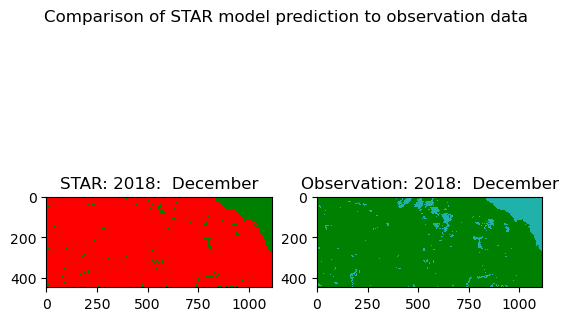

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison of STAR model prediction to observation data')

def animate(i):
    ax1.clear()
    ax2.clear()
    object1 = ax1.imshow(pred_class_data[(12*16) + i], cmap=cmap, vmin=0, vmax=2)
    object2 = ax2.imshow(class_data[(12*16) + i], cmap=cmap, vmin=0, vmax=2)
    ax1.set_title(f'STAR: {2016 + (i // 12)}: {month_dict[i % 12]}')
    ax2.set_title(f'Observation: {2016 + (i // 12)}: {month_dict[i % 12]}')
    return [object1, object2]

ani = animation.FuncAnimation(fig, animate, repeat=False, blit=True, frames=36, interval=400)
# To save the animation using Pillow as a gif

ani.save('STAR-comparison-smaller.gif', writer=animation.PillowWriter(fps=1))

In [1]:
np.unique(Prediction_arr[12*16+18])

NameError: name 'np' is not defined